# Chapter 6 Code

We start with some imports.

In [1]:
import numpy as np
import matplotlib.pyplot as plt
from numba import jit, vectorize
from interpolation import interp
from scipy.interpolate import interp1d
from scipy.optimize import minimize_scalar, brentq
from scipy.stats import beta



## First Steps

Here is the code that generated figure 6.1.

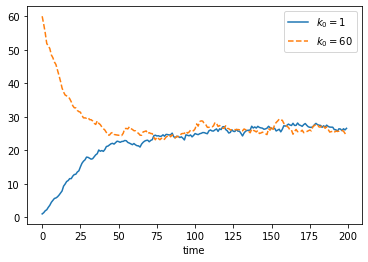

In [2]:
alpha = 0.5  # capital intensity
sigma = 0.2  # shock parameter
s = 0.5      # savings rate
delta = 0.1  # depreciation

default_params = alpha, sigma, s, delta

@jit
def f(k, params=default_params):
    alpha, sigma, s, delta = params
    return k**alpha

@jit
def update(k, params=default_params):
    alpha, sigma, s, delta = params
    w = np.exp(sigma * np.random.randn())
    new_k = s * f(k) * w + (1 - delta) * k
    return new_k

@jit
def generate_solow_ts(init=1, ts_length=200, params=default_params):
    " A function to generate time series. "
    k = np.empty(ts_length)
    k[0] = init
    for t in range(ts_length-1):
        k[t+1] = update(k[t], params=params)
    return k

fig, ax = plt.subplots()

ax.plot(generate_solow_ts(init=1), label='$k_0 = 1$')
ax.plot(generate_solow_ts(init=60), '--', label='$k_0 = 60$')
ax.legend()
ax.set_xlabel('time')
#plt.savefig('solow_ts.pdf')
plt.show()


Here is a function to generate draws from the time $t$ marginal distribution of
capital.

In [3]:
@jit
def sim_from_marginal(t=10, init=1, sim_size=100_000, params=default_params):
    k_draws = np.empty(sim_size)
    for i in range(sim_size):
        k = init
        for j in range(t):
            k = update(k, params=params)
        k_draws[i] = k
    return k_draws

Now we generate some draws for date $t=20$ under the default parameters and
take the mean, which solves exercise 6.2.

In [4]:
draws = sim_from_marginal(t=20)
draws.mean()

12.79988924614681

Here is the solution to exercise 6.3.

In [5]:
new_s = 3/4
new_params = alpha, sigma, new_s, delta
draws = sim_from_marginal(t=20, params=new_params)
draws.mean()

26.580349450573284

Not surprisingly, mean capital stock at this (and any given) date is higher,
due to higher savings.


Here is the solution to exercise 6.4.

In [6]:
init_values = 5, 10, 20
for init_k in init_values:
    draws = sim_from_marginal(t=20, init=init_k)
    print(f"Mean capital from initial condition {init_k} is {draws.mean():.2f}")

Mean capital from initial condition 5 is 16.45
Mean capital from initial condition 10 is 19.35
Mean capital from initial condition 20 is 23.74


Higher initial capital leads to higher mean capital at $t=20$.

This is as expected, since the law of motion for capital is increasing in
lagged capital.


Here is the solution to exercise 6.5.

In [7]:
dates = 50, 100, 200
for date in dates:
    draws = sim_from_marginal(t=date)
    print(f"Mean capital at {date} is {draws.mean():.2f}")

Mean capital at 50 is 22.74
Mean capital at 100 is 25.74
Mean capital at 200 is 25.98


Mean capital is slightly increasing, although it stabilizes as $t \to \infty$.

The initial increase is due to the fact that the initial condition is
relatively small.  Hence we see growth on average, as shown in the time series
plot starting from $k_0=1$ above.

For exercise 6.6 we compute the 95% confidence interval as follows

In [8]:
draws = sim_from_marginal(t=20)
n = len(draws)
k_bar = draws.mean()
sigma_hat = draws.std()
c = 1.96

lower = k_bar - (sigma_hat / np.sqrt(n)) * c
upper = k_bar + (sigma_hat / np.sqrt(n)) * c

print(f"Sample mean is {k_bar:.4f}")
print("The 95% Confidence interval is ", [round(x, 4) for x in (lower, upper)])


Sample mean is 12.7960
The 95% Confidence interval is  [12.7894, 12.8026]


For exercise 6.7 we approximate steady state consumption at a range of savings
values using the method described in the exercise.

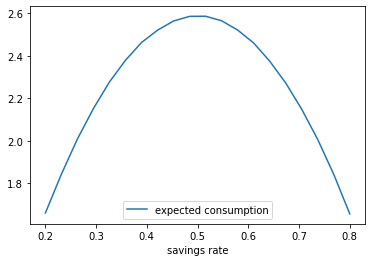

In [9]:
m = 100_000
min_s, max_s, grid_size = 0.2, 0.8, 20
savings_rates = np.linspace(min_s, max_s, grid_size)
expected_consumption = np.empty_like(savings_rates)

for i, s in enumerate(savings_rates):
    params = alpha, sigma, s, delta
    draws = sim_from_marginal(t=100, sim_size=m, params=params)
    w_vec = np.exp(sigma * np.random.randn(m))
    c_bar = np.mean( (1-s) * f(draws) * w_vec )
    expected_consumption[i] = c_bar

fig, ax = plt.subplots()

ax.plot(savings_rates, expected_consumption, label='expected consumption')
ax.legend()
ax.set_xlabel('savings rate')
#plt.savefig('solow_golden.pdf')
plt.show()


Exercise 6.8 asks us to compute the empirical distribution of $\psi_t$ when
$t=20$ at different sample sizes.

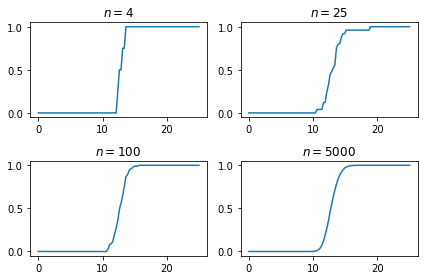

In [10]:
fig, axes = plt.subplots(2, 2)
axes = axes.flatten()
sample_sizes = 4, 25, 100, 5000
grid_points = np.linspace(0, 25, 100)

for ax, n in zip(axes, sample_sizes):
    draws = sim_from_marginal(t=20, sim_size=n)
    ecdf_vals = [np.mean(draws <= x) for x in grid_points]
    ax.plot(grid_points, ecdf_vals)
    ax.set_title(f"$n={n}$")

plt.tight_layout()
#plt.savefig('solow_ecdf.pdf')
plt.show()


Our next task is to simulate from the "threshold exernalities" model.

The following code generates figures 6.5 and 6.6.

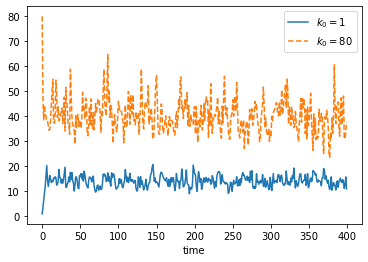

In [11]:
alpha = 0.5     # capital intensity
s = 0.25        # savings rate
sigma = 0.14    # shock parameter
delta = 1.0     # depreciation
A1, A2 = 15, 25
k_b = 21.6


@jit
def A(k):
    return A1 if k < k_b else A2

@jit
def f(k):
    return k**alpha

@jit
def update(k):
    w = np.exp(sigma * np.random.randn())
    new_k = s * A(k) * f(k) * w + (1 - delta) * k
    return new_k

@jit
def generate_ad_ts(init=1, ts_length=400):
    k = np.empty(ts_length)
    k[0] = init
    for t in range(ts_length-1):
        k[t+1] = update(k[t])
    return k

fig, ax = plt.subplots()

ax.plot(generate_ad_ts(init=1), label='$k_0 = 1$')
ax.plot(generate_ad_ts(init=80), '--', label='$k_0 = 80$')
ax.legend()
ax.set_xlabel('time')
#plt.savefig('adtssim.pdf')
plt.show()


The next piece of code computes an approximation of the first passage time
above $k_b$ using simulation.

In [12]:
@jit
def draw_tau():
    tau = 0
    k = 1
    while k < k_b: 
        k = update(k)
        tau += 1
    return tau

def tau_draws(m=10_000):
    draws = np.empty(m)
    for i in range(m):
        draws[i] = draw_tau()

print(np.mean(draws))

12.820127211007364


Here is a solution to Exercise 6.11, which implements a kernel density
estimator and tests it on some data.

The kernel density estimator uses a Gaussian kernel and is implemented via a closure.

We use the `vectorize` decorator from Numba to ensure that the function can act
correctly on arrays as well as scalars.

In [13]:
k0 = np.sqrt(1 / (2 * np.pi))  # for Gaussian kernel
@jit
def K(z):
    return k0 * np.exp(-z**2)

def kde_factory(data, delta):

    @vectorize
    def kde(x):
        return (1 / delta) * np.mean( K((x - data) / delta) )

    return kde

Now we produce the figure.

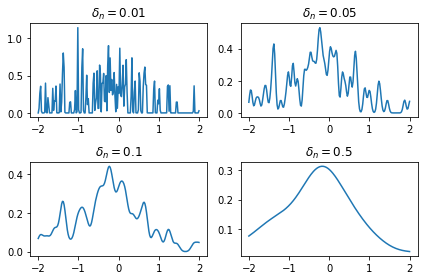

In [14]:
Y = np.random.randn(100)
deltas = 0.01, 0.05, 0.1, 0.5
x_grid = np.linspace(-2, 2, 200)

fig, axes = plt.subplots(2, 2)
axes = axes.flatten()

for delta, ax in zip(deltas, axes):
    f = kde_factory(Y, delta)
    ax.plot(x_grid, f(x_grid))
    ax.set_title(f"$\delta_n = {delta}$")

plt.tight_layout()
#plt.savefig("kdes.pdf")
plt.show()


Next we turn to exercise~6.8, which concerns the STAR model.

We will use a `jitclass`, which requires us to set up parameters.

In [15]:
from numba import float64
from numba.experimental import jitclass

star_data = (
    ('alpha_0', float64),
    ('alpha_1', float64),
    ('beta_0', float64),
    ('beta_1', float64)
)

Next we set up the class, which implements the law of motion and the
stochastic kernel.

In [16]:
@jitclass(star_data)
class STAR:

    def __init__(self, alpha_0=-4.0, alpha_1=0.4, beta_0=5.0, beta_1=0.6):

        self.alpha_0, self.alpha_1 = alpha_0, alpha_1
        self.beta_0, self.beta_1 = beta_0, beta_1

    def G(self, x):
        " Logistic function "
        return 1 / (1 + np.exp(-x))

    def g(self, x):
        " Smooth transition function "
        a = (self.alpha_0 + self.alpha_1 * x) * (1-self.G(x)) 
        b = (self.beta_0 + self.beta_1 * x) * self.G(x)
        return a + b

    def update(self, x):
        " Update by one time step. "
        W = np.random.randn()
        return self.g(x) + W

    def draws_from_marginal(self, t_date, init=0, n=10_000):
        draws = np.empty(n)
        for i in range(n):
            X = init
            for t in range(t_date):
                X = self.update(X)
            draws[i] = X
        return draws

    def phi(self, z):
        " Standard normal density "
        return k0 * np.exp(-z**2)

    def p(self, x, y):
        " Stochastic kernel "
        return self.phi(y - self.g(x))

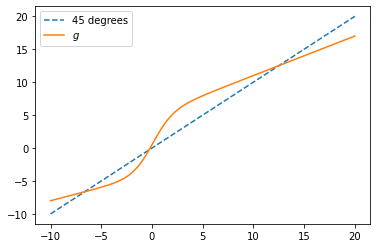

In [17]:
s = STAR()
x_grid = np.linspace(-10, 20, 200)

fig, ax = plt.subplots()
ax.plot(x_grid, x_grid, '--', label='45 degrees')
ax.plot(x_grid, s.g(x_grid), label='$g$')
ax.legend()

#plt.savefig("star_g.pdf")
plt.show()

Now we use a closure to produce a look ahead estimator of the time $t$
marginal given a stochastic kernel and a set of draws from time $t+1$.

In [18]:
def lae_factory(p, x_data):
    
    def f(y):
       return np.mean(p(x_data, y))

    return f
    

This code solves exercise 6.12.

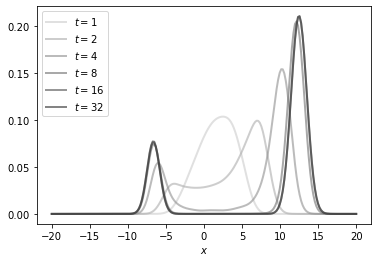

In [19]:
dates = 1, 2, 4, 8, 16, 32
y_grid = np.linspace(-20, 20, 200)
greys = [str(g) for g in np.linspace(0.2, 0.8, len(dates))]
greys.reverse()

s = STAR()

fig, ax = plt.subplots()

for t, g in zip(dates, greys):
    x_obs = s.draws_from_marginal(t)
    f = lae_factory(s.p, x_obs)
    ax.plot(y_grid, 
            [f(y) for y in y_grid], 
            color=g, 
            lw=2, 
            alpha=0.6,
            label=f'$t={t}$')

ax.set_xlabel('$x$')
ax.legend()

#plt.savefig("starseq.pdf")
plt.show()

Solutions to exercises 6.13 -- 6.15 are omitted.  They can be solved using
techniques similar to those described above and immediately below.

We complete section 6.1 by solving exercise 6.16.

In [20]:
ad_data = (
    ('alpha', float64),
    ('s', float64),
    ('sigma', float64),
    ('A1', float64),
    ('A2', float64),
    ('k_b', float64),
)


@jitclass(ad_data)
class AD:

    def __init__(self, 
            alpha=0.5,
            s=0.25,  
            sigma=0.14,
            A1=15, 
            A2=25,
            k_b = 21.6):

        self.alpha, self.s, self.sigma = alpha, s, sigma
        self.A1, self.A2, self.k_b = A1, A2, k_b

    def A(self, k):
        return self.A1 * (k < self.k_b) + self.A2 * (k >= self.k_b)

    def f(self, k):
        return k**self.alpha

    def update(self, k):
        w = np.exp(self.sigma * np.random.randn())
        new_k = self.s * self.A(k) * self.f(k) * w 
        return new_k

    def generate_ts(self, init=1, ts_length=100_000):
        k = np.empty(ts_length)
        k[0] = init
        for t in range(ts_length-1):
            k[t+1] = self.update(k[t])
        return k

    def phi(self, z):
        " Lognormal density for N(0, sigma^2) "
        a = k0 / (z * self.sigma)
        b = np.exp(- np.log(z)**2 / (2 * self.sigma**2))
        return a * b

    def p(self, x, y):
        z = y / (self.s * self.A(x) * self.f(x))
        return self.phi(z) / z
        

Now we use the class to generate the figure.

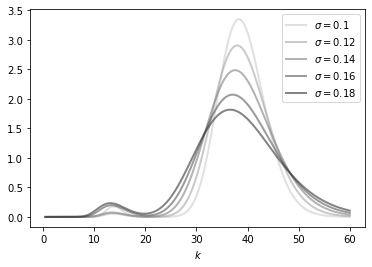

In [21]:
sigmas = 0.1, 0.12, 0.14, 0.16, 0.18
y_grid = np.linspace(0, 60, 140)
greys = [str(g) for g in np.linspace(0.2, 0.8, len(sigmas))]
greys.reverse()

fig, ax = plt.subplots()

for sigma, g in zip(sigmas, greys):
    ad = AD(sigma=sigma)
    x_obs = ad.generate_ts()
    f = lae_factory(ad.p, x_obs)
    ax.plot(y_grid, 
            [f(y) for y in y_grid], 
            color=g, 
            lw=2, 
            alpha=0.6,
            label=f'$\sigma={sigma}$')

ax.set_xlabel('$k$')
ax.legend()

#plt.savefig("ad_sdla.pdf")
plt.show()

## Optimal Savings

Optimization routines in the Python numerical tool set typically perform
minimization.

It is useful for us to have a function 
maximizises a map g over an interval [a, b].

We use the fact that the maximizer of g on any interval is also the minimizer
of -g.

In [22]:
def maximize(g, a, b, args):
    """
    Returns the maximal value and the maximizer.
    The tuple args collects any extra arguments to g.
    """
    objective = lambda x: -g(x, *args)
    result = minimize_scalar(objective, bounds=(a, b), method='bounded')
    maximizer, maximum = result.x, -result.fun
    return maximizer, maximum

In [23]:
class OptimalSaving:

    def __init__(self,
                 U,            # utility function
                 R=1.05,       # gross return on saving
                 rho=0.96,     # discount factor
                 b=0.1,        # shock scale parameter
                 grid_max=2,
                 grid_size=120,
                 shock_size=250,
                 seed=1234):

        self.U, self.R, self.rho, self.b = U, R, rho, b

        # Set up grid
        self.grid = np.linspace(1e-4, grid_max, grid_size)

        # Store shocks (with a seed, so results are reproducible)
        np.random.seed(seed)
        self.shocks = np.exp(b * np.random.randn(shock_size))

    def state_action_value(self, s, a, v_array):
        """
        Right hand side of the Bellman equation.
        """

        U, R, rho, shocks = self.U, self.R, self.rho, self.shocks

        v = interp1d(self.grid, 
                     v_array, 
                     fill_value=(v_array[0], v_array[-1]),
                     bounds_error=False)

        return U(a-s) + rho * np.mean(v(R * s + shocks))


In the last line, the expectation is computed via Monte Carlo.


Now we write up the Bellman operator.

In [24]:
def T(v, os):
    """
    The Bellman operator.  Updates the guess of the value function
    and also computes a v-greedy policy.

      * os is an instance of OptimalSaving
      * v is an array representing a guess of the value function

    """
    v_new = np.empty_like(v)
    v_greedy = np.empty_like(v)

    for i in range(len(os.grid)):
        a = os.grid[i]

        # Maximize RHS of Bellman equation at state a
        c_star, v_max = maximize(os.state_action_value, 1e-10, a, (a, v))
        v_new[i] = v_max
        v_greedy[i] = c_star

    return v_greedy, v_new

Here is a figure showing the function sequence generated by value function
iteration, starting at the utility function.

In [25]:
def solve_model(os,
                tol=1e-4,
                max_iter=1000,
                verbose=True,
                print_skip=25):
    """
    Solve the model by iterating with the Bellman operator.

    * os is an instance of OptimalSaving

    """

    # Set up loop
    v = U(os.grid)  # Initial condition
    i = 0
    error = tol + 1

    while i < max_iter and error > tol:
        v_greedy, v_new = T(v, os)
        error = np.max(np.abs(v - v_new))
        i += 1
        if verbose and i % print_skip == 0:
            print(f"Error at iteration {i} is {error}.")
        v = v_new

    if i == max_iter:
        print("Failed to converge!")

    if verbose and i < max_iter:
        print(f"\nConverged in {i} iterations.")

    return v_greedy, v_new

Let us put this code to work.

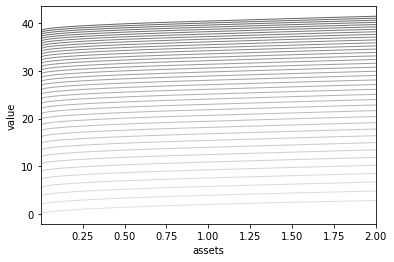

In [26]:
@jit       
def U(c, gamma=0.5):
    "The utility function."
    return c**(1 - gamma) / (1 - gamma)

os = OptimalSaving(U)

#v = U(os.grid)  # Initial condition
v = np.zeros_like(os.grid)  # Initial condition
n = 40          # Number of iterations
greys = [str(g) for g in np.linspace(0.0, 0.8, n)]
greys.reverse()

fig, ax = plt.subplots()

for i in range(n):
    v_greedy, v = T(v, os)  # Apply the Bellman operator
    ax.plot(os.grid, v, color=greys[i], lw=1.0, alpha=0.6)

ax.set_xlabel('assets')
ax.set_ylabel('value')
ax.set(xlim=(np.min(os.grid), np.max(os.grid)))
plt.show()


The next code block uses a more systematic method to find a good approximation
to the value function and then computes the associated greedy policy.

Error at iteration 25 is 0.7349889566690351.


Error at iteration 50 is 0.2648838502200732.


Error at iteration 75 is 0.09546326991188181.


Error at iteration 100 is 0.0344046490568104.


Error at iteration 125 is 0.012399322564725423.


Error at iteration 150 is 0.004468675143598944.


Error at iteration 175 is 0.001610495850478344.


Error at iteration 200 is 0.000580417417040735.


Error at iteration 225 is 0.00020918053152030325.



Converged in 244 iterations.


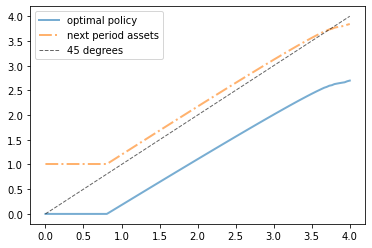

In [27]:
os = OptimalSaving(U, grid_max=4)
sigma_star, v_star = solve_model(os)

fig, ax = plt.subplots()

ax.plot(os.grid, sigma_star, 
        label='optimal policy', lw=2, alpha=0.6)
ax.plot(os.grid, os.R * sigma_star + 1.01, '-.', 
        label='next period assets', lw=2, alpha=0.6)
ax.plot(os.grid, os.grid, 'k--', 
        label='45 degrees', lw=1, alpha=0.6)

ax.legend()
plt.show()


Now we use the look-ahead estimator to compute asset density dynamics under
the optimal policy.

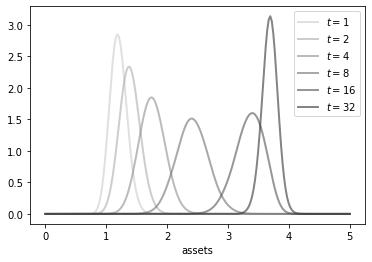

In [28]:
# Turn the policy array into a function
sigma = lambda x: interp(os.grid, sigma_star, x)

@vectorize
def phi(z, b):
    " Lognormal density for N(0, b^2) "
    if z <= 0:
        return 0
    else:
        c1 = k0 / (z * b)
        c2 = np.exp(- np.log(z)**2 / (2 * b**2))
        return c1 * c2

def p(x, y):
    return phi(y - os.R * sigma(x), os.b)

def draws_from_marginal(t_date, init=0, n=10_000):
    draws = np.empty(n)
    for i in range(n):
        a = init
        for t in range(t_date):
            xi = np.exp(os.b * np.random.randn())
            a = os.R * sigma(a) + xi
        draws[i] = a
    return draws

dates = 1, 2, 4, 8, 16, 32
greys = [str(g) for g in np.linspace(0.2, 0.8, len(dates))]
greys.reverse()
grid = np.linspace(0, 5, 200)

fig, ax = plt.subplots()

for t, g in zip(dates, greys):
    a_obs = draws_from_marginal(t)
    f = lae_factory(p, a_obs)
    ax.plot(grid, 
            [f(y) for y in grid], 
            color=g, 
            lw=2, 
            alpha=0.6,
            label=f'$t={t}$')

ax.set_xlabel('assets')
ax.legend()

plt.show()


Finally we turn to policy function iteration, in order to solve exercise 6.19.

We need to compute the value of any feasible policy $\sigma$.

To do so we will iterate with the policy value operator $T_\sigma$.

In [29]:
def T_sigma(v, sigma, os):
    """
    Here os is an instance of OptimalSaving and v and sigma
    are both arrays defined on the grid.
    """
    v_new = np.empty_like(v)


    sigma_interp = interp1d(os.grid, 
                     sigma, 
                     fill_value=(sigma[0], sigma[-1]),
                     bounds_error=False)

    for i in range(len(os.grid)):
        a = os.grid[i]
        v_new[i] = os.state_action_value(sigma_interp(a), a, v)

    return v_new

To compute the policy value we iterate until convergence, starting
from some guess of $v_sigma$ represented by `v_guess`.

In [30]:
def compute_policy_value(os,
                         sigma,
                         v_guess=None,
                         tol=1e-3,
                         max_iter=1000):

    if v_guess is None:
        v_guess = U(os.grid)  
    v = v_guess
    i = 0
    error = tol + 1

    while i < max_iter and error > tol:
        v_new = T_sigma(v, sigma, os)
        error = np.max(np.abs(v - v_new))
        i += 1
        v = v_new

    return v_new

We will use existing code to get a greedy policy from a guess $v$ of the value
function.

In [31]:
def get_greedy(v, os):
    sigma, _ = T(v, os)
    return sigma

In [32]:
def policy_iteration(os, tol=1e-3, max_iter=1e5, verbose=True):

    sigma = np.zeros_like(os.grid)      # Initial condition is consume everything
    v_guess = U(os.grid)                # Starting guess for value function
    i = 1

    while i < max_iter:
        v_sigma = compute_policy_value(os, sigma, v_guess=v_guess)
        new_sigma = get_greedy(v_sigma, os)
        if np.abs(np.max(new_sigma - sigma)) < tol:
            break
        else:
            sigma = new_sigma
            v_guess = v_sigma   # Use last computed value to start iteration
            i += 1

    if i == max_iter:
        print("Failed to converge!")

    if verbose and i < max_iter:
        print(f"\nConverged in {i} iterations.")

    return sigma


Running the following code produces essentially the same figure we obtained
for the optimal policy when using value function iteration, just as we hoped.


Converged in 7 iterations.


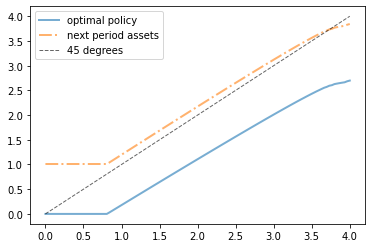

In [33]:
os = OptimalSaving(U, grid_max=4)
sigma_star = policy_iteration(os)

fig, ax = plt.subplots()

ax.plot(os.grid, sigma_star, 
        label='optimal policy', lw=2, alpha=0.6)
ax.plot(os.grid, os.R * sigma_star + 1.01, '-.', 
        label='next period assets', lw=2, alpha=0.6)
ax.plot(os.grid, os.grid, 'k--', 
        label='45 degrees', lw=1, alpha=0.6)

ax.legend()
plt.show()


## Stochastic Speculative Price


Finally, to conclude code for this chapter, we turn to the commodity pricing
model.

The next code block computes figure 6.16 and hence solves exercise 6.26.

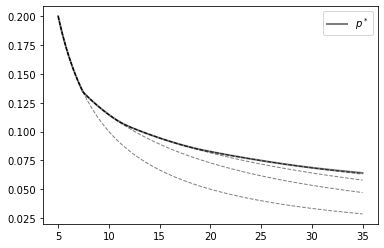

In [34]:
alpha, a, c = 0.8, 5.0, 2.0                           
beta_a, beta_b = 5, 5
mc_draw_size = 250
gridsize = 150
grid_max = 35
grid = np.linspace(a, grid_max, gridsize)

beta_dist = beta(5, 5)
W = a + beta_dist.rvs(mc_draw_size) * c    # Shock observations
D = P = lambda x: 1.0 / x   
tol = 1e-4

def fix_point(h, lower, upper):
    "Computes the fixed point of h on [upper, lower]."
    return brentq(lambda x: x - h(x), lower, upper)

def T(p_array):

    new_p = np.empty_like(p_array)

    # Interpolate to obtain p as a function.
    p = interp1d(grid, 
                 p_array, 
                 fill_value=(p_array[0], p_array[-1]),
                 bounds_error=False)

    for i, x in enumerate(grid):
        y = alpha * np.mean(p(W))
        if y <= P(x): 
            new_p[i] = P(x)  
            continue
        h = lambda r: alpha * np.mean(p(alpha*(x - D(r)) + W))
        new_p[i] = fix_point(h, P(x), y)

    return new_p


fig, ax = plt.subplots()

price = P(grid)
error = tol + 1
while error > tol:
    ax.plot(grid, price, 'k--', alpha=0.5, lw=1)
    new_price = T(price)
    error = max(np.abs(new_price - price))
    price = new_price

ax.plot(grid, price, 'k-', alpha=0.5, lw=2, label=r'$p^*$')
ax.legend()

plt.show()


Our final task for this chapter is to solve exercise 6.27, which involves
computing the stationary density of the associated state process for
quantities.

To do so we use the look ahead estimator.

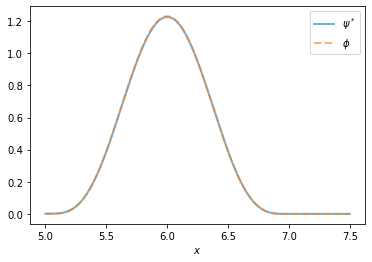

In [35]:
# Turn the price array into a price function
p_star = lambda x: interp(grid, price, x)

def carry_over(x):
    return alpha * (x - D(p_star(x)))

def phi(z):
    "Shock distribution computed by change of variables."
    return beta_dist.pdf((z - a)/c) / c

def p(x, y):
    return phi(y - carry_over(x))

def generate_cp_ts(init=0, n=1000):
    X = np.empty(n)
    X[0] = init
    for t in range(n-1):
            W = a + c * beta_dist.rvs()
            X[t+1] = carry_over(X[t]) + W
    return X

fig, ax = plt.subplots()

plot_grid = np.linspace(a, a * 1.5, 200)

x_ts = generate_cp_ts()
f = lae_factory(p, x_ts)
ax.plot(plot_grid, 
        [f(y) for y in plot_grid], 
        lw=2, 
        alpha=0.6,
        label=r'$\psi^*$')
ax.plot(plot_grid, 
        phi(plot_grid),
        '--',
        lw=2, 
        alpha=0.6,
        label=r'$\phi$')

ax.set_xlabel('$x$')
ax.legend()

plt.show()


As claimed in the statement of the exercise, the two distributions line up
exactly.

Hence, for these particular parameters, speculation has no impact on long run
average outcomes.

If we change parameters to make storage more attractive, then we will see
differences between the distributions.